# Model building

----------

This notebook details the model building (i.e. machine learning) steps for the project. First, we load in all relevant packages and functions. We also set global options as well as define useful functions. 

In [1]:
#Import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

#Import from scikit-learn
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, Normalizer, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier


#Set some global options
pd.set_option('max_columns',100) #Its nice to see all columns

#Set some global plot defaults
sns.set(rc={"figure.figsize": (15, 8), 'legend.fontsize': 18}) # figsize and leg fontsize of seaborn plots
plt.rc('axes' , labelsize=18)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('axes' , titlesize=18)                                  # fontsize of the plot title

In [2]:
#Global df to hold score results for the models
model_results = pd.DataFrame(columns=['Model', 'Test score', 'CV score'])

def get_scores(model, name='unk'):
    #Print the score/metric for the input model which must be fit
    
    #Make prediction for the model
    pred = model.predict(x_test)
    
    #Calculate the score on the entire test set
    f1s = f1_score(y_test, pred, average='weighted')
    
    #Calculate the score on CV test set
    cv_scores = cross_val_score(model, x_test, y_test, cv=the_cv, scoring=score_func)
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    
    #Save the results to global dataframe
    model_results.loc[len(model_results)] = [name, f1s, mean_cv]
    
    #Save to local dataframe to be used for printing only
    model_score = pd.DataFrame(columns=['Model', 'Test score', 'CV score'])
    model_score.loc[0] = [name, f1s, mean_cv]
    model_score.set_index('Model', inplace=True)
    print(model_score)

In [3]:
def plotCVResults(results, x, p=''):
    #Plot the results of the CV fit with the given x-axis var and potential parameter
    
    #Convert cv_results to a dataframe
    res = pd.DataFrame(results)
    
    #Get the correct string names for the var/param
    str_p = 'param_' + p
    str_x = 'param_' + x
    
    #Count the params
    param = p.split('__')[-1]
    n_param = res.groupby(str_p).ngroups
    i_param = res.groupby(str_p).count().index

    #Seperate the train/test results
    test = res.pivot(index = str_p, columns = str_x, values='mean_test_score').T
    train= res.pivot(index = str_p, columns = str_x, values='mean_train_score').T

    #Plot the results
    color = ['r', 'g', 'b', 'p']
    for i in range(n_param):
        plt.plot( test[i_param[i]],  'o-%s' % color[i], label= 'Test; %s = %s' % (param, i_param[i]))
        plt.plot(train[i_param[i]], 'o--%s' % color[i], label='Train; %s = %s' % (param, i_param[i]))
    plt.xlabel(x.split('__')[-1])
    plt.ylabel('Score')
    plt.legend()    

------------

We would like to optimize and compare models to find the best one. But first we need to get our cleaned dataset. 

## Load data

We have our data in a pickle file which we load into a dataframe. We can also print out a few rows of the dataset to remind ourselves of our data. 

In [4]:
df = pd.read_pickle('data/cleaned_df.pkl')

df['round'] = df['round'].astype(int) #Make sure the target var is an int

In [5]:
df.sample(5)

,name,year,college,position,height,weight,fortyyd,vertical,bench,threecone,shuttle,broad,wonderlic,nflgrade,arms,hands,team,round,pick,overall,positiongroup
5486,Corey Graham,2007.0,New Hampshire,CB,72.0,195.0,4.42,36.0,10.0,6.97,4.17,120.0,12.0,5.30,31.500,9.250,Bears,5,31.0,168.0,DB
5673,John Parker Wilson,2009.0,Alabama,QB,73.0,219.0,4.75,29.5,19.0,7.53,4.59,105.0,26.0,5.25,32.250,9.625,NaN,-1,-1.0,-1.0,QB
5172,Levron Williams,2002.0,Indiana,RB,75.0,224.0,4.66,34.0,16.0,7.09,4.25,117.0,24.0,5.20,31.000,9.250,NaN,-1,-1.0,-1.0,BA
1997,Troy Kropog,2009.0,Tulane,OT,77.0,309.0,5.30,30.0,21.0,7.65,4.84,100.0,23.0,5.30,33.875,10.000,Titans,4,35.0,135.0,OL
5253,Greg Brooks,2004.0,Southern Miss,CB,71.0,177.0,4.45,36.0,15.0,6.97,4.17,120.0,12.0,5.30,31.500,9.250,Bengals,6,18.0,183.0,DB


Next, we drop unneeded columns and convert our one categorical column, **positiongroup**, into dummy columns. But first we make a duplicate dataframe. 

In [6]:
thedf = df.copy()
thedf.drop(['name','college','position','pick','overall','team'], axis=1, inplace=True)
thedf = pd.get_dummies(thedf, drop_first=True) #Drop first dummy column, since it is correlated to the others

thedf.sample(5)

,year,height,weight,fortyyd,vertical,bench,threecone,shuttle,broad,wonderlic,nflgrade,arms,hands,round,positiongroup_DB,positiongroup_DL,positiongroup_LB,positiongroup_OL,positiongroup_QB,positiongroup_RE,positiongroup_ST
2292,2008.0,71.0,201.0,4.54,33.5,16.0,7.31,4.38,116.0,12.0,5.3,31.5,9.250,4,1,0,0,0,0,0,0
4030,2002.0,73.0,211.0,4.43,35.0,15.0,7.25,4.22,116.0,12.0,5.3,31.5,9.250,4,1,0,0,0,0,0,0
1496,2011.0,75.0,195.0,4.54,38.0,16.0,6.82,4.33,125.0,12.0,5.3,32.0,9.750,5,1,0,0,0,0,0,0
2594,2007.0,74.0,201.0,4.58,36.5,17.0,6.99,4.19,125.0,16.0,5.3,32.5,9.375,-1,0,0,0,0,0,1,0
3426,2004.0,73.0,233.0,4.73,34.0,17.0,7.16,4.30,116.0,23.0,5.3,32.5,9.625,-1,0,0,1,0,0,0,0


Finally, we make numpy arrays of our predictor variables and target variable. These x and y vars are our data. Note our target is a multi-class value, one of eight classes is to be predicted.

In [7]:
target = 'round'
x = thedf.drop(target, axis=1).values
y = thedf[target].values

## Split into train/test

Before splitting our data into training and testing sets, we should remind ourselves of our target variable, the draft **round**. The predicted classes are unbalanced so we must be mindful of this fact. Recall a value of -1 here means a player went undrafted. 

In [8]:
#Percent of players drafted or not
thedf.groupby('round').size()*100./len(thedf)

round
-1    36.321304
 1     9.263263
 2     9.263263
 3     9.579245
 4    10.194578
 5     9.030434
 6     8.032596
 7     8.315317
dtype: float64

Because more than a third of players in our dataset go undrafted, we have to be careful with this unbalance. 

We can stratify the splitting to ensure we do not have biased training and testing data. We use train_test_split to separate our data into 80% training data and 20% testing data. We give a seed value so we can consitently have the same train-test split when running.

In [9]:
#Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1221, stratify=y)

print('The train data has %.0f rows which is %.2f%% of the total. ' % (len(x_train), len(x_train)*100./len(thedf)))
print('The  test data has %.0f rows which is %.2f%% of the total. ' % (len(x_test),  len(x_test) *100./len(thedf)))

The train data has 4810 rows which is 79.99% of the total. 
The  test data has 1203 rows which is 20.01% of the total. 


## Scoring metric

There are a few metrics we could use such as accuracy, precision, ROC AUC, and logistic loss. We will use the F1 score which is a harmonic mean of precision and recall. However, we have multiple classes to predict so we calculate these values per class, or label, weighted by the support, or number of true labels. Note again we weight these values because we have a class imbalance. 

In [10]:
score_func = make_scorer(f1_score, greater_is_better=True, average='weighted')

## Cross-Validation Scheme

It is important to use cross-validation (CV) to estimate the performance of our models. We want to not only optimize a single method but also compare methods against each other to determine the best one. 

Here we use a stratified k-fold scheme. This should help perform internal cross-validation on the training data we will feed it. There will be 5 folds. we enable shuffling to match test_train_split which also shuffles before splitting. we also use the stratified k-fold method, and not the usual k-fold, to again mirror the fact that we have unbalanced classes. We will also set a seed here, so we can consistently get the same folds. 

In [11]:
the_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1220)

## Building models

Now we are ready to build a model to predict which **round** a player is drafted. But we also should establish a baseline. We need a way to establish that our model is better than what we can do naively. In this case, since we have a class encompassing over a third of our dataset, the smartest naive thing is to always predict that a player goes undrafted. If we used this dummy strategy, we would be correct 36% of the time (in terms of accuracy). 

### Dummy classifier

In [12]:
dummy = DummyClassifier('most_frequent')
dummy.fit(x_train, y_train)
pred = dummy.predict(x_test)
print('Dummy Strategy  --  Accuracy: %0.4f  F1-score: %0.4f' % (accuracy_score(y_test, pred), 
                                                                f1_score(y_test, pred, average='weighted')))

Dummy Strategy  --  Accuracy: 0.3633  F1-score: 0.1936


/Users/pjandir/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


This dummy classifier indeed does have an accuracy of 36% as we expected. We are also given a baseline F1 score which we can compare with out other models. Any model that we build should have a higher score than this one--otherwise it is fairly worthless. 

With this done, we can go build our first real model. In this case, we start simple with a Logistic Regression (logreg). 

### Logistic Regression

In [13]:
#Set class weights to reflect the imbalance in classes
logreg = LogisticRegression(class_weight='balanced', solver='newton-cg', penalty='l2', n_jobs=-1) 

#### Tune hyperparameters

Using GridSearchCV, we want to optimize the parameters to find the best LogisticRegression model for our data. We will feed the CV method with our stratified k-folds we defined earlier. A simple parameter grid is constructed to test various C values for the L2 penalty.

So let's setup that grid.

In [14]:
param_grid = {'logreg__C' : np.logspace(-5, 5, 20)}

Now we setup the pipeline, again with a scaler, for the logreg we already created. 

Note we will also use a pipeline to scale our data before we acutally fit it. The reason is that some of our columns have very different ranges and values. The year column has values from 1999 to 2015, while the fortyyd column has values from 4.2 to 6.1. Using a pipeline should makes it easier to test out different scalers, if any. In this case, the MaxAbsScaler seems to work best. This scales each column by its maximum value so that it ranges from 0 to 1. In addition we can easily add another piece to our model building process, such as adding a PCA stage (see end of this notebook).

In [15]:
steps = [('scaler', MaxAbsScaler()),
         ('logreg', logreg)]
pipeline = Pipeline(steps)

Then we make our GridSearchCV object with our created pipeline, parameter grid, cv method, and metric.

In [16]:
logreg_cv = GridSearchCV(pipeline, param_grid, cv=the_cv, scoring=score_func)

Now we can fit our train data with this GridSearchCV object. This will help us find the best parameters to get the best model we can.

In [17]:
logreg_cv.fit(x_train, y_train)

#Print out the best model
print('Best Logistic Reg Params: {}'.format(logreg_cv.best_params_))
print('Best Logistic Reg Score : %f' % logreg_cv.best_score_)

Best Logistic Reg Params: {'logreg__C': 8858.6679041008319}
Best Logistic Reg Score : 0.289159


#### Best model

Here we use the best parameters from the GridSearchCV to create and fit the best logreg model.

In [18]:
#Create new 'best params' logreg
steps = [('scaler', MaxAbsScaler()),
         ('logreg', LogisticRegression(C=logreg_cv.best_params_['logreg__C'], class_weight='balanced',
                                       solver='newton-cg', penalty='l2', n_jobs=-1)
         )]
logreg_best = Pipeline(steps)

logreg_best.fit(x_train, y_train)

Pipeline(steps=[('scaler', MaxAbsScaler(copy=True)), ('logreg', LogisticRegression(C=8858.6679041008319, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False))])

Having created our optimal logreg model, we can also visualize the coefficients from the model. This is an advantage of this method, we can easily visualize the results of the fit. The plot below is a 2-D map showing the fit coefficient for each feature (y-axis) vs draft **round** (x-axis). 

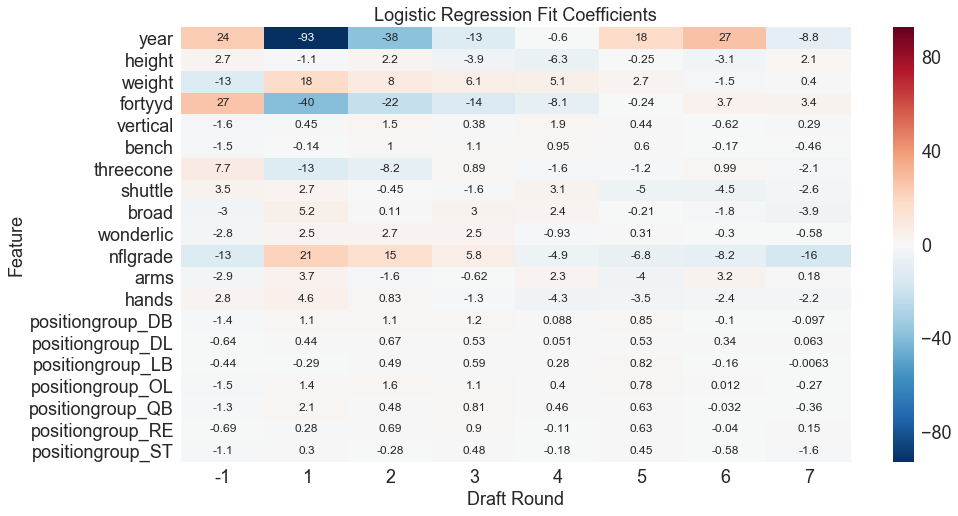

In [19]:
#Get names/labels for plot
df_columns = thedf.drop(target, axis=1).columns.values
df_rounds = thedf[target].value_counts().sort_index().index

#Plot the fit coefficients
sns.heatmap(pd.DataFrame(logreg_best.named_steps['logreg'].coef_, index=df_rounds, columns=df_columns).T, 
            annot=True)
plt.xlabel('Draft Round')
plt.ylabel('Feature')
plt.title('Logistic Regression Fit Coefficients')
plt.show()

We can see that the **positiongroup** dummy variables do not seem to have a large effect on draft **round**. Focusing on the **fortyyd** feature (recall it is the 40yd sprint), the fit seems to say that the first few **rounds** preferentially have lower **fortyyd** times than the last few. Players who are not drafted tend to be the slowest. This seems to make sense. Similar interpretations can be made for the other features as well.

#### Evaluate the 'best' model

To evaluate the actual performance of the 'best' model we have, we must calculate the F1 score. We can simply calculate the score over the test data (the stuff we held out in the train-test split). This gives us a performance value on unseen data so it is independent measurement of our previous calculation. 

However, we should really be using CV here as well to evaluate the performance: cross_val_score. In fact we can use the exact same CV scheme too, namely 'the_cv,' within the cross_val_score function. This should give us a robust method to evaluate the score and evaluate the estimator. 

We can use a defined function (see the top of this notebook) to get both these scores for a model. But first we will get the scores for our previous dummy classifier to remind ourselves of our baseline.

In [20]:
get_scores(dummy, 'Dummy')

       Test score  CV score
Model                      
Dummy     0.19359  0.193604


In [21]:
get_scores(logreg_best, 'LogReg')

        Test score  CV score
Model                       
LogReg    0.283957   0.25864


The two metrics are different for our logreg model, as should be expected. The CV F1 score is the metric we are really interested in, while the general F1 score from the entire test dataset is not. The latter score is nice to see but ultimately not the one used for model evaluation.

Now we can repeat the preceding steps for additional models and compare which one performs best.

### k-Nearest Neighbors

In [22]:
#The estimator
knn = KNeighborsClassifier(weights='distance', algorithm='brute', n_jobs=-1)

We can test the k-Nearest Neighbors (k-NN) algorithm for our data to see how it performs. We first find the optimal parameters for the model. 

In [23]:
#Tune hyperparameters
param_grid = {'knn__n_neighbors' : range(2,15,1), 'knn__p' : range(1,3,1)}

steps = [('scaler', StandardScaler()),
         ('knn', knn)]
pipeline = Pipeline(steps)

knn_cv = GridSearchCV(pipeline, param_grid, cv=the_cv, scoring=score_func)
knn_cv.fit(x_train, y_train)

#Print out the best model
print('Best k-NN Params: {}'.format(knn_cv.best_params_))
print('Best k-NN Score : %f' % knn_cv.best_score_)

Best k-NN Params: {'knn__p': 1, 'knn__n_neighbors': 7}
Best k-NN Score : 0.301101


We can plot the results of the hyperparameter search and check the performance. The plot below shows the F1 score against the n_neighbors parameter on the x-axis. The p parameter is shown in different colors while the internal test and train data is shown in different line styles.

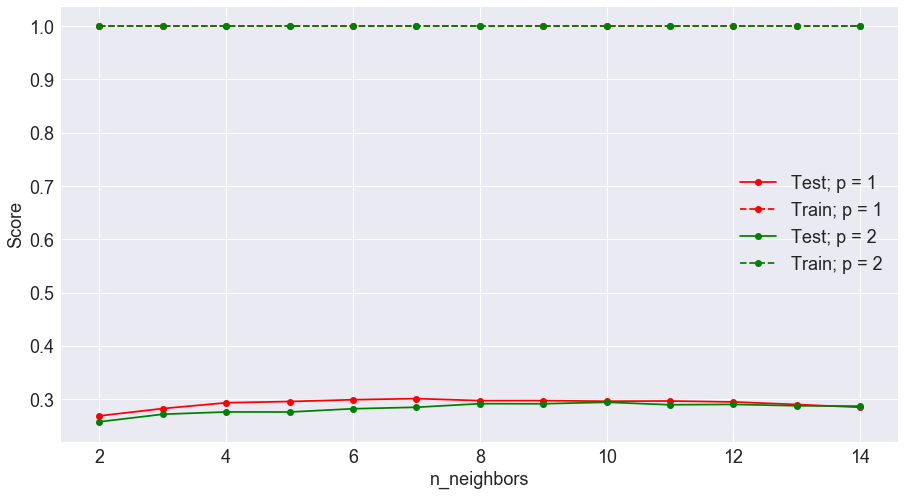

In [24]:
plotCVResults(knn_cv.cv_results_, 'knn__n_neighbors', 'knn__p')
plt.show()

We can see there is a huge difference between the test and train scores. This means the algorithm is overfitting and is not able to accurately model the data. Regardless, we will trust the CV test scores. With the optimized k-NN, we can then create a new, best k-NN model.

In [25]:
#Create 'best' k-NN model
steps = [('scaler', StandardScaler() ),
         ('knn', KNeighborsClassifier(n_neighbors=knn_cv.best_params_['knn__n_neighbors'], 
                                      p=knn_cv.best_params_['knn__p'], weights='distance', n_jobs=-1)
         )]
knn_best = Pipeline(steps)

knn_best.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=7, p=1,
           weights='distance'))])

In [26]:
get_scores(knn_best, 'k-NN')

       Test score  CV score
Model                      
k-NN     0.309431  0.265932


We see that the k-NN model does not perform as well as the logreg. So we move onto the next algorithm: Support Vector Classifier (SVC).

### Support Vector Classifier

In [27]:
#The estimator
svc = SVC(kernel='rbf', probability=True, class_weight='balanced')

In [28]:
#Tune hyperparameters
param_grid = {'svc__C' : np.logspace(2, 4, 3), 'svc__gamma' : [0.001, 0.01]}
steps = [('scaler', StandardScaler()),
         ('svc', svc)]
pipeline = Pipeline(steps)

svc_cv = GridSearchCV(pipeline, param_grid, cv=the_cv, scoring=score_func, n_jobs=-1)
svc_cv.fit(x_train, y_train)

#Print out the best model
print('Best SVC Params: {}'.format(svc_cv.best_params_))
print('Best SVC Score : %f' % svc_cv.best_score_)

Best SVC Params: {'svc__gamma': 0.01, 'svc__C': 100.0}
Best SVC Score : 0.281497


We can again visualize the hyperparameter optimization as before. 

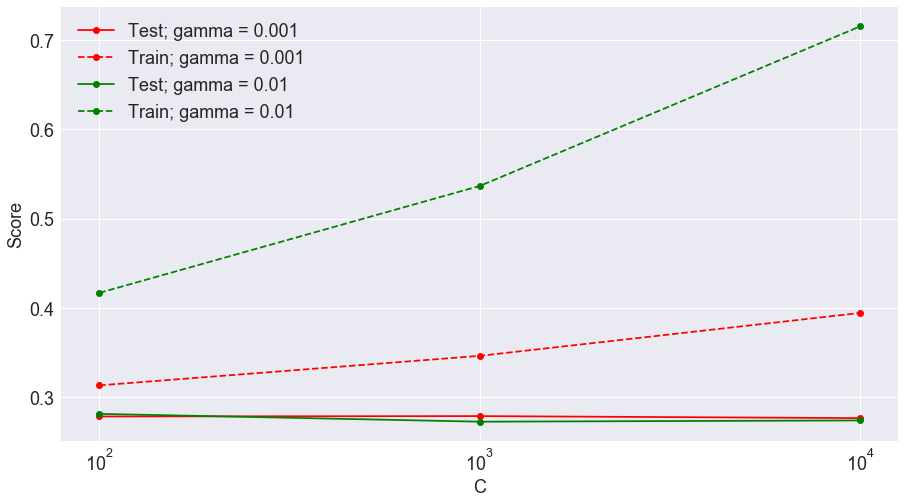

In [29]:
plotCVResults(svc_cv.cv_results_, 'svc__C', 'svc__gamma')
plt.xscale('log')
plt.show()

We can see that a gamma of 0.001 and C of 1,000 gives the best model. The overfitting is also not too large for gamma of 0.001, which is reassuring. Next we create the optimal SVC model, as before.

In [30]:
#Create 'best' svc model
steps = [('scaler', StandardScaler()),
         ('svc', SVC(kernel='rbf', probability=True, C=svc_cv.best_params_['svc__C'], 
                     gamma=svc_cv.best_params_['svc__gamma'], class_weight='balanced') 
         )]
svc_best = Pipeline(steps)

svc_best.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [31]:
get_scores(svc_best, 'SVC')

       Test score  CV score
Model                      
SVC      0.271583  0.213857


We see that the SVC model performs approximately as well as the k-NN model. Thus far then, the logreg model is the best one so far. 

We can move onto another popular algorithm: Random Forests (RF). Multiple decision trees are grown from the data with replacement. Instead of using all features to chose a node to split, a random subset of features is used instead. This is a RF model.

### Random Forest

In [32]:
#The estimator
rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1)

#Tune hyperparameters
param_grid = {'rf__n_estimators' : [250, 300, 350], 'rf__min_samples_split' : [6, 7, 8], 
              'rf__max_depth' : [70, 80, 90]}
steps = [('rf', rf)]
pipeline = Pipeline(steps)

rf_cv = GridSearchCV(pipeline, param_grid, cv=the_cv, scoring=score_func)
rf_cv.fit(x_train, y_train)

#Print out the best model
print('Best RF Params: {}'.format(rf_cv.best_params_))
print('Best RF Score : %f' % rf_cv.best_score_)

Best RF Params: {'rf__min_samples_split': 7, 'rf__max_depth': 80, 'rf__n_estimators': 300}
Best RF Score : 0.335661


Scaling is not really necessary here since decision trees are used. We also leave in the pipeline for consistency. 

In [33]:
#Create 'best' RF model
steps = [('rf', RandomForestClassifier(criterion='gini', n_estimators=rf_cv.best_params_['rf__n_estimators'],
                                       min_samples_split=rf_cv.best_params_['rf__min_samples_split'], 
                                       max_depth=rf_cv.best_params_['rf__max_depth'],
                                       class_weight='balanced', n_jobs=-1)
         )]
rf_best = Pipeline(steps)

rf_best.fit(x_train, y_train)

Pipeline(steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [34]:
get_scores(rf_best, 'RF')

       Test score  CV score
Model                      
RF        0.33966  0.284427


The RF performs better than all other models tested thus far. This perhaps makes sense as it is an ensemble method using many, many weak learners so can fit the data better. We can test another similar method which takes the randomness even further than a RF, Extremely Randomized Trees (ERT). In addition to using a random subset of features, random thresholds are used for the splits as well. Let's see how this method fares against a RF.

### Extremely Randomized Trees

In [35]:
#The estimator
ert = ExtraTreesClassifier(bootstrap=True, class_weight='balanced', n_jobs=-1)

#Tune hyperparameters
param_grid = {'ert__n_estimators' : [250, 300, 350], 'ert__min_samples_split' : [5, 6, 7], 
              'ert__max_depth' : [45, 50, 55]}
steps = [('ert', ert)]
pipeline = Pipeline(steps)

ert_cv = GridSearchCV(pipeline, param_grid, cv=the_cv, scoring=score_func)
ert_cv.fit(x_train, y_train)

#Print out the best model
print('Best ERT Params: {}'.format(ert_cv.best_params_))
print('Best ERT Score : %f' % ert_cv.best_score_)

Best ERT Params: {'ert__min_samples_split': 6, 'ert__max_depth': 45, 'ert__n_estimators': 350}
Best ERT Score : 0.326888


In [36]:
#Create 'best' ERT model
steps = [('ert', ExtraTreesClassifier(n_estimators=ert_cv.best_params_['ert__n_estimators'],
                                      min_samples_split=ert_cv.best_params_['ert__min_samples_split'], 
                                      max_depth=ert_cv.best_params_['ert__max_depth'],
                                      class_weight='balanced', bootstrap=True, n_jobs=-1)
         )]
ert_best = Pipeline(steps)

ert_best.fit(x_train, y_train)

Pipeline(steps=[('ert', ExtraTreesClassifier(bootstrap=True, class_weight='balanced',
           criterion='gini', max_depth=45, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=6,
           min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [37]:
get_scores(ert_best, 'ERT')

       Test score  CV score
Model                      
ERT      0.320806   0.27552


We again go through the hyperparameter optimization and find the best ERT model. Comparing to RF, we see that it has similar performance. However, RF seems to edge it out. We can now turn to the last model, of sorts, to test.

### Majority Rule Classifier

We can use scikit-learn's VotingClassifier to implement another ensemble method. This can take in any number (>1) of classifiers. Each classifier is given a vote for predictions, with a majority rule. This has advantages of balancing out weaknesses in our models while retaining their strengths. Because our models do not have very different F1 scores, it is worth trying this to see if additional accuracy can be bought by this method. Any potential model instabilities can be ironed out with this type of method.

The k-NN and ERT models are left out since the k-NN performs poorly compared to the rest while overfitting badly and the ERT is worse than its simpler cousin, the RF. We will also use the predicted probabilities and not the prediction itself when voting. This has the advantage of avoiding scenarios with any ties. 

Note that we can weight the votes of each model so that some have greater voting power. Let's go through a quick (brute-force) search to find which weights would be best, if any. 

In [38]:
#Adapted from: http://sebastianraschka.com/Articles/2014_ensemble_classifier.html

#Store results of search
voting_weights = pd.DataFrame(columns=('w_lg', 'w_sv', 'w_rf', 'score'))

#Get results for equal weights, first (i.e. the default)
vclf = VotingClassifier([('lr', logreg_best), ('svc', svc_best), ('rf', rf_best)], voting='soft')
vclf.fit(x_train, y_train)

voting_weights.loc[0] = [1, 1, 1, f1_score(y_test, vclf.predict(x_test), average='weighted')]

#Loop through different weight combinations
i = 1
for w_lg in range(1,3):
    for w_sv in range(1,3):
        for w_rf in range(1,4):

            #Skip when all weights are equal
            if len(set((w_lg, w_sv, w_rf))) == 1:
                continue
            
            #Setup clf with weights
            vclf = VotingClassifier([('lr', logreg_best), ('svc', svc_best), ('rf', rf_best)], 
                                    voting='soft', weights=[w_lg, w_sv, w_rf])
            vclf.fit(x_train, y_train)

            #Save results
            voting_weights.loc[i] = [w_lg, w_sv, w_rf, f1_score(y_test, vclf.predict(x_test), average='weighted')]
            i += 1

#Print sorted results            
voting_weights.sort_values(by='score', ascending=False, inplace=True)
voting_weights

,w_lg,w_sv,w_rf,score
2,1.0,1.0,3.0,0.336841
8,2.0,1.0,3.0,0.334967
7,2.0,1.0,2.0,0.332347
1,1.0,1.0,2.0,0.327806
5,1.0,2.0,3.0,0.327220
10,2.0,2.0,3.0,0.323204
6,2.0,1.0,1.0,0.321265
0,1.0,1.0,1.0,0.314870
4,1.0,2.0,2.0,0.313075
3,1.0,2.0,1.0,0.301775


We can see that weighting the RF model more than the other two models seem to give the better models. We can also see that the equal weights scenario gives a below average result. Let's take the best-case scenario and see how it does. 

In [39]:
#Get the best weights
vweights_best = list(voting_weights.iloc[0,:3])

#Create ensemble classifier
vclf = VotingClassifier([('lr', logreg_best), ('svc', svc_best), ('rf', rf_best)], voting='soft', 
                        weights=vweights_best)

#Re-fit
vclf.fit(x_train, y_train)

#Calculate the score
get_scores(vclf, 'Ensemble')

          Test score  CV score
Model                         
Ensemble    0.330368  0.299254


## Comparing models

So we can make a comparison between the best models of each algorithm. Recall, the last number in the dataframe is the CV score. By this evaluation, the best individual model is Random Forest. But the ensemble method is able to improve on all the individual component models and has the best score. Then we will select this ensemble classifier as the final model. 

In [40]:
model_results

,Model,Test score,CV score
0,Dummy,0.193590,0.193604
1,LogReg,0.283957,0.258640
2,k-NN,0.309431,0.265932
3,SVC,0.271583,0.213857
4,RF,0.339660,0.284427
5,ERT,0.320806,0.275520
6,Ensemble,0.330368,0.299254


We can also check how the ensemble predicts the test data. Using a cross tabulation we can construct a confusion matrix to see the distribution of the predictions vs the actuals. 

In [41]:
pd.crosstab(vclf.predict(x_test), y_test, rownames=['Predicted Round'], colnames=['Actual Round'])

Actual Round,-1,1,2,3,4,5,6,7
Predicted Round,,,,,,,,
-1,357,14,37,50,65,64,60,65
1,23,65,25,27,23,7,13,9
2,9,11,17,8,8,11,4,5
3,15,14,10,13,9,5,5,6
4,9,2,13,7,10,7,2,4
5,13,3,5,7,3,10,8,5
6,5,0,2,2,3,3,4,1
7,6,2,2,1,2,2,1,5


It is clear the model likes to predict that a player goes undrafted a lot. It tends to get players in the higher rounds more incorrect as well. This makes some amount of sense as there can be little difference between a player drafted in the last round and a player not drafted at all. 

## The final model

Now that we have finalized our model, we train it over the whole dataset. This is our final model which we can use for future predictions. We can then save this model so that we can directly use it later for predictions or any other purpose.

In [42]:
#Create ensemble classifier
final_model = VotingClassifier([('lr', logreg_best), ('svc', svc_best), ('rf', rf_best)], voting='soft', 
                               weights=vweights_best)

#Re-fit to full dataset
final_model.fit(x, y)

#Though not necessary, we can calculate the score on the whole dataset
f1_score(y, final_model.predict(x), average='weighted')

0.95232103344206243

In [43]:
#Save this model to a pickle file
with open('final_model.pkl', 'wb') as file:  
    pickle.dump(final_model, file)

-----------------

## Other considerations

There were several other techniques and methods explored in the context of building machine learning models. The two prominent steps included here are dimensionality reduction and feature importance. They were not used in this particular analysis but can be a crucial part of the workflow. So while they did not quite fit the flow of this notebook, for posterity are placed below. 

### Dimensionality reduction

We can explore some dimension reduction with this data. With the dummy variables, we have 20 features in our dataset. It might be prudent to try to see if reducing the dimensionality of the dataset is useful. We can do this by first scaling and normalizing the data and applying PCA. Then we can visualize the results. 

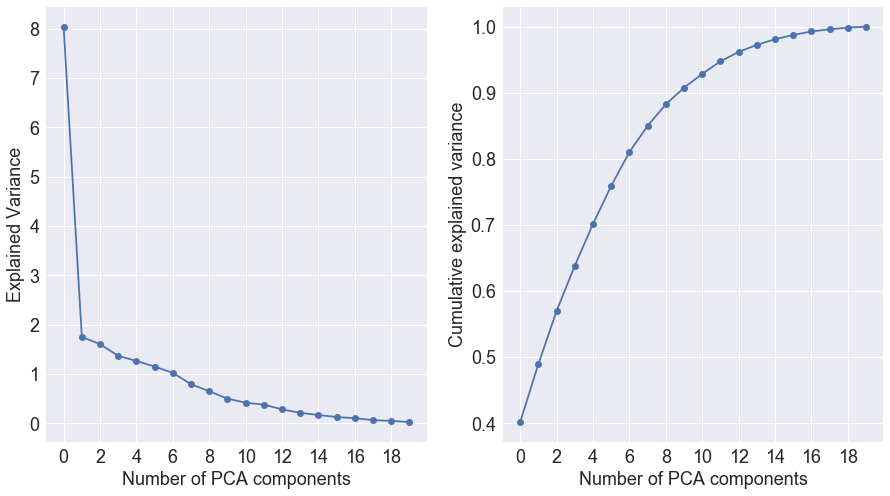

In [44]:
#Setup PCA pipeline
steps = [('scaler', StandardScaler()),
         ('pca', PCA())]
pipeline = Pipeline(steps)

pipeline.fit(x_test)

#Plot the explained variances
fig, axes = plt.subplots(1,2)
features = range(pipeline.named_steps['pca'].n_components_)

axes[0].plot(features, pipeline.named_steps['pca'].explained_variance_, 'o-')
axes[0].set_xlabel('Number of PCA components')
axes[0].set_ylabel('Explained Variance')
axes[0].set_xticks(range(0, pipeline.named_steps['pca'].n_components_, 2))

axes[1].plot(np.cumsum(pipeline.named_steps['pca'].explained_variance_ratio_), 'o-')
axes[1].set_xlabel('Number of PCA components')
axes[1].set_ylabel('Cumulative explained variance')
axes[1].set_xticks(range(0, pipeline.named_steps['pca'].n_components_, 2))

plt.show()

By plotting the explained variances for various number of PCA components, we can see if there is a good dimensionality that exists which explains most of the data but in fewer dimensions. Usually we want the cumulative plot (right plot) to show an elbow or kink indicating an optimal number of PCA components. This plot has no clear suggestion which is corroborated by the right plot. A value between 2 to 6 components might be the best as higher values show diminishing returns. 

While not shown here, through testing its been seen that no number of components seems to help. So while a useful exercise, PCA did not improve any model any significant amount. Therefore, the models were fed all features in the dataset. 

### Feature importance

An important aspect of tree based ensemble methods is their ability to calculate which features are most valuable for the prediction. This is known as feature importance and the results of both the RF (red) and ERT (green) model are shown below. Both show similar results though with some notable differences.  

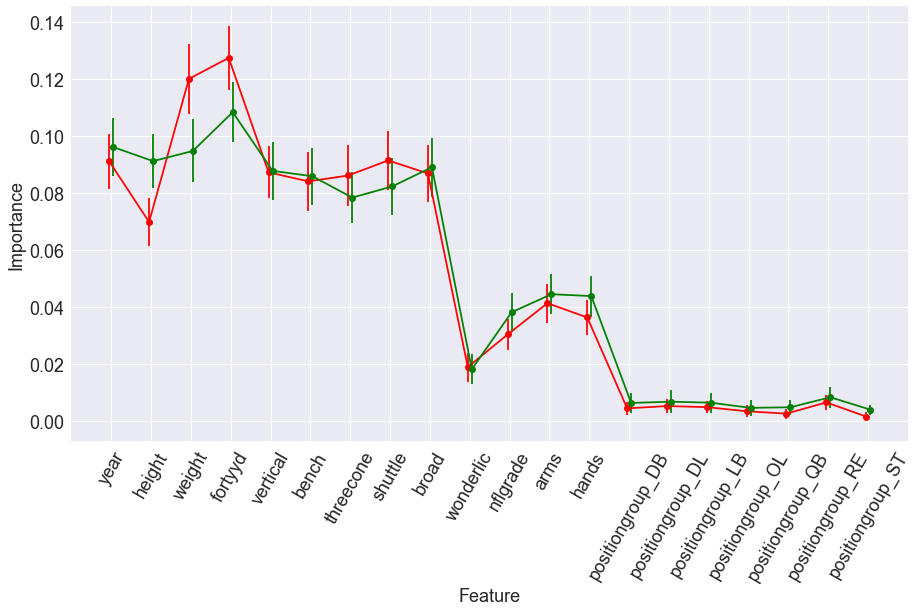

In [45]:
#Calculate std of feature importances
rf_std  = np.std([tree.feature_importances_ for tree in  rf_best.named_steps['rf'] .estimators_], axis=0)
ert_std = np.std([tree.feature_importances_ for tree in ert_best.named_steps['ert'].estimators_], axis=0)

#Plot with error bars (and offset)
plt.errorbar(np.arange(len(df_columns))-0.05,  rf_best.named_steps['rf']. feature_importances_, yerr= rf_std, 
            fmt='o-r')
plt.errorbar(np.arange(len(df_columns))+0.05, ert_best.named_steps['ert'].feature_importances_, yerr=ert_std, 
            fmt='o-g')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(np.arange(len(df_columns)), df_columns, rotation=60)
plt.legend()

plt.show()

The RF pays greater attention to the **weight** and **fortyyd** features on the right side of the plot (from **year** to **broad**). The ERT meanwhile seems to give near equal weight to all of those features, except **fortyyd**. Both agree that the **fortyyd** is an important feature to predict where a player might be drafted. This conclusion agrees with the earlier logreg coefficients heatmap. In fact both plots seem to be in agreement on which features likely are important and which ones  likely are not. For convenience, the logreg fit coefficients are shown again below.

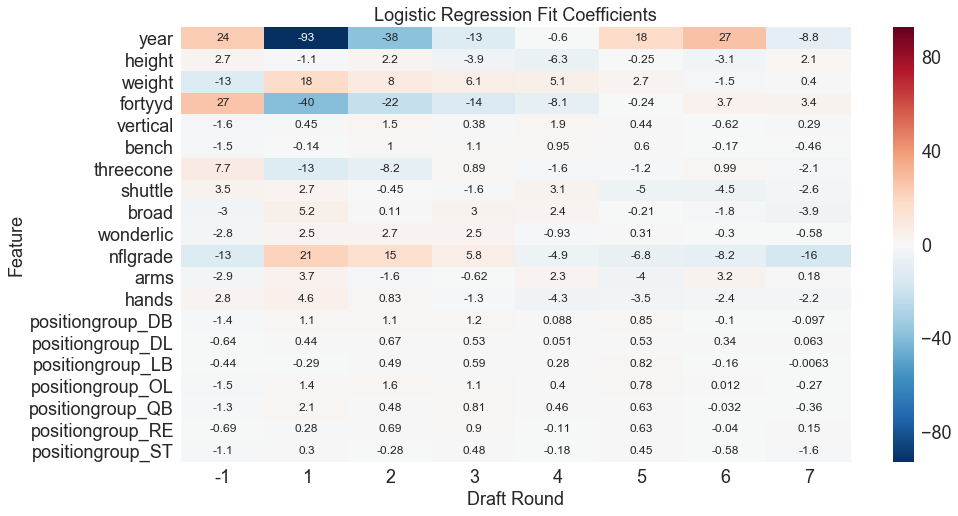

In [46]:
#Plot the logreg fit coefficients
sns.heatmap(pd.DataFrame(logreg_best.named_steps['logreg'].coef_, index=df_rounds, columns=df_columns).T, 
            annot=True)
plt.xlabel('Draft Round')
plt.ylabel('Feature')
plt.title('Logistic Regression Fit Coefficients')
plt.show()

------------------

Et fin.